In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import mpld3
import seaborn as sn
import numpy as np
import os
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
sn.set_context('notebook')

# ICP Waters climate data processing

Heleen would like historic climate data for the sites involved in the updated TOC trends analysis (see e-mail received 07/02/2017 at 13.33 for details).

I have downloaded 0.5 degree resolution global gridded data with a monthly time step from the Climate Research Unit (CRU; dataset details [here](https://crudata.uea.ac.uk/cru/data/hrg/)). I have also contacted [Ian Harris](https://www.uea.ac.uk/environmental-sciences/people/profile/i-harris), the main scientist behind these datasets, to ask whether a compatible elevation dataset is also available - see his reply received 16/02/2017 at 16.12. In addition, I have downloaded a separate 0.5 degree resolution elevation dataset from [here](http://research.jisao.washington.edu/data_sets/elevation/)), which may also be useful. The aim of this notebook is as follows:

 * Extract latitude/longitude co-ordinates and elevations from RESA2 for all the stations involved in the updated trends analysis. The list of sites to use is here:
 
   C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\Results\trends_sites_oct_2016.xlsx <br><br>

 * Extract the grid cell elevations for each site from the elevation dataset. <br><br>
 
 * For the period from 1990 to 2012, calculate the following summary statistics for both average temperature (`tmp`) and precipitation (`pre`): <br><br>
 
   * Average **annual** temperature and precipitation for the period of interest <br><br>
   * Average **summer (JJA)** temperature and precipitation for the period of interest <br><br>
   * Average **summer (JAS)** temperature and precipitation for the period of interest <br><br>

 * In addition, for the time periods 1990 to 2012, 1990 to 2004 and 1998 to 2012, calculate: <br><br>
 
   * Trends in the above 6 quantities over the duration of the time period of interest, calculated using the Theil-Sen estimator. <br><br>
   * Trend significance for the above 6 quantities estimated using the Mann-Kendall method
 
 Note that the mean temperature estimates should all be corrected for the difference between pixel elevation and actual site elevation according to the **lapse rate**. The actual lapse rate is highly variable, but Heleen would like to use a value of 0.6C/100m (see e-mail received 23/01/2017 at 11.49).
 
Heleen would also like to add a fourth time period (1990 to 1992) to the trends analysis. Note that for this period we are **only interested in median TOC, ECa_EMg and ECaX_EMgX**. I'll probably do this separately to keep the original trends code as clean as possible.

Finally, much of this processing is similar to the work Leah needs to do for the DOMQUA project. I'm therefore going to investigate the various options for climate data processing in a bit more detail than strictly necessary for ICPW, as I suspect the methods will be useful later.
 
## 1. Site data

The `readme` sheet of *trends_sites_oct_2016.xlsx* lists the RESA2 projects agreed with Heleen for inclusion in the updated trends analysis. I have extracted site data (co-ordinates and elevations) for all the sites associated with these projects. There are 609 sites in total, including some Swedish sites with no data. I'll ignore this issue for now and simply extract the climate data for the whole lot.

Three of the Norwegian sites in the database have only local (UTM Zone 33) co-ordinates. I've corrected this by manually converting the co-ordinates [here](http://home.hiwaay.net/~taylorc/toolbox/geography/geoutm.html). In addition, a number of the sites do not have elevation information. **My code will ignore these sites**, but if we get elevations for them in the future we can simply re-run this analysis.

The spreadsheet of site data is here:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\CRU_Climate_Data\toc_trends_sites_for_climate.xlsx

In [2]:
# Read station data
in_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
          r'\CRU_Climate_Data\toc_trends_sites_for_climate.xlsx')

stn_df = pd.read_excel(in_xls, sheetname='DATA')

# Drop sites without elevations
stn_df.dropna(how='any', inplace=True)
   
stn_df.head()

,stn_id,stn_code,stn_name,lat,lon,elev_m
0,23469,CA20,"Ontario,Lake373",49.740,-93.793,424.0
1,23459,CA08,"Quebec, Lac Laflamme",47.317,-71.117,777.0
2,23468,CA19,Ontario. Lake 305,49.689,-93.686,404.0
3,23455,CA04,"Ontario, Algoma Region, Turkey Lake",47.050,-84.408,372.0
4,23460,CA09,"Quebec, Lac Macleod",47.467,-70.973,975.0


## 2. Elevation data

There are lots of options for processing the elevation and climate data. In the past, I've usually written my own code for this and used the [Basemap](http://matplotlib.org/basemap/) library for plotting, but I have recently discovered [xarray](http://xarray.pydata.org/en/stable/), which might offer some more sophisticated options, especially for data stored in netCDF files. I want to investigate both below.

### 2.1. Read gridded elevation data using Basemap

We'll start by working with the 0.5 degree netCDF dataset from [here](http://research.jisao.washington.edu/data_sets/elevation/).

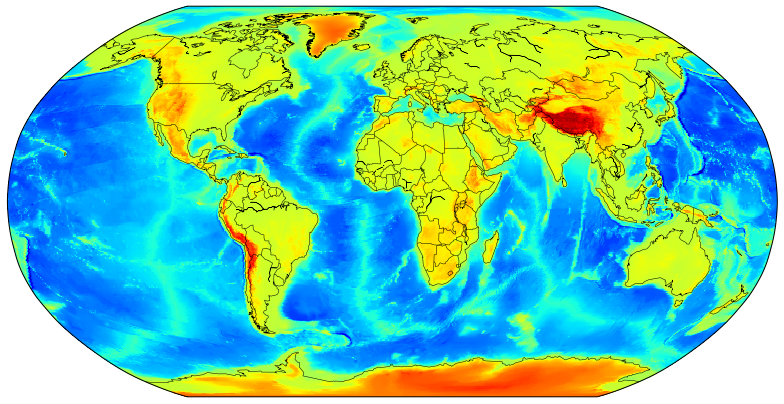

In [3]:
# Open elevation netCDF  
nc_file = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\elevation\elev.0.5-deg.nc')
nc_data = Dataset(nc_file, 'r')

# Read lat and long grids from netCDF
lats = nc_data.variables['lat'][:]
lons = nc_data.variables['lon'][:]

# Read the elevation data
elev = nc_data.variables['data'][:]

# Plot 
fig = plt.figure(figsize=(14, 7))

# Robinson projection
m = Basemap(projection='robin', lon_0=0, resolution='c')

# Create grid of lon-lat coordinates 
xx, yy = np.meshgrid(lons, lats)

# Plot elev grid
im = m.pcolormesh(xx, yy, elev[0,:,:], latlon=True, cmap=plt.cm.jet) 

# Annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)

Next, compare this to the dataset supplied by Ian Harris. Note that this dataset is shifted 180 degrees compared to the one above: zero longitude is taken to be the international dateline. I therefore need to shift the longitudes by 180 degrees (and this will probably need doing with the CRU climate data too).

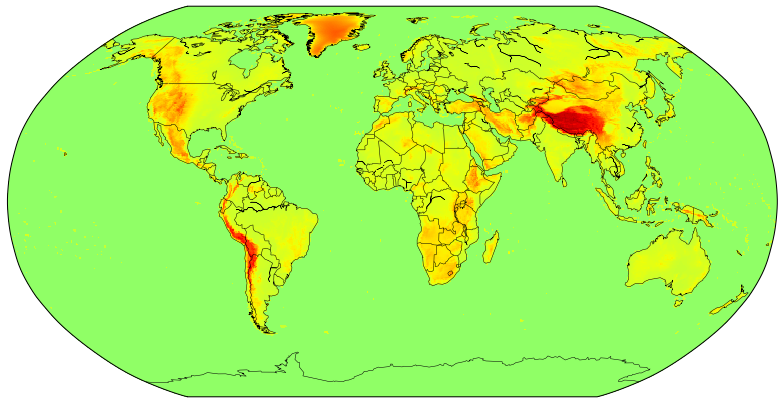

In [4]:
# Read the elev data from Ian
dat_file = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
            r'\CRU_Climate_Data\elevation\halfdeg.elv.grid.dat')
elev2 = np.loadtxt(dat_file, dtype=int)
elev2 = elev2[::-1, :] # Flip data N-S, as numpy indexes arrays from the top down

# Plot 
fig = plt.figure(figsize=(14, 7))

# Robinson projection
m = Basemap(projection='robin', lon_0=0, resolution='c')

# Create grid of lon-lat coordinates 
# Shifting lons by -180 degrees
xx, yy = np.meshgrid(lons - 180, lats)

# Plot elev grid
# Use the same colour scheme as on map above for comparison
im = m.pcolormesh(xx, yy, elev2, latlon=True, cmap=plt.cm.jet,
                  vmin=elev[0].min(), vmax=elev[0].max()) 

# Annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)

Apart from the sea, these two maps look identical to me. The first map includes bathymetry, whereas the second only covers the land and all offshore areas are assigned the NoData value of -999, which is why all the oceans are coloured as though they were 1 km deep.

### 2.2. Read gridded elevation data using xarray

xarray should make the this all much simpler, especially because it includes tools for extracting time series for co-ordinates of interest. xarray datasets are essentially in-memory netCDF files.

In [5]:
# Read elev data
nc_file = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\elevation\elev.0.5-deg.nc')
ds = xr.open_dataset(nc_file)
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1)
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 87.75 87.25 86.75 86.25 ...
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 ...
  * time     (time) datetime64[ns] 2001-01-01
Data variables:
    data     (time, lat, lon) float64 -4.29e+03 -4.29e+03 -4.291e+03 ...
Attributes:
    history: 
Elevations calculated from the TBASE 5-minute
latitude-longitude resolution elevation data set.
TBASE is available from the NCAR data archive at 
ftp://ncardata.ucar.edu/datasets/ds759.2/ 
Calculation and netCDF file written by Todd Mitchell in August 2000.
The file is written in COARDS-compliant netCDF:
http://ferret.wrc.noaa.gov/noaa_coop/coop_cdf_profile.html
The file was written at the JISAO at the University of Washington.
http://jisao.washington.edu

xarray automatically reads metadata from the netCDF file, so as long as the file conforms to netCDF standards it becomes very easy to work with. This file has two spatial co-ordinates (`lat` and `lon`) and one time co-ordinate (`time`). The time co-ordinate has just a single entry, which has been set arbitrarily to 01/01/2001 (because time isn't especially relevant to this static elevation dataset). The file also has one variable called `data`, which is indexed by the co-ordinates `lat`, `lon` and `time`.

Plotting this data is wonderfully straightforward!

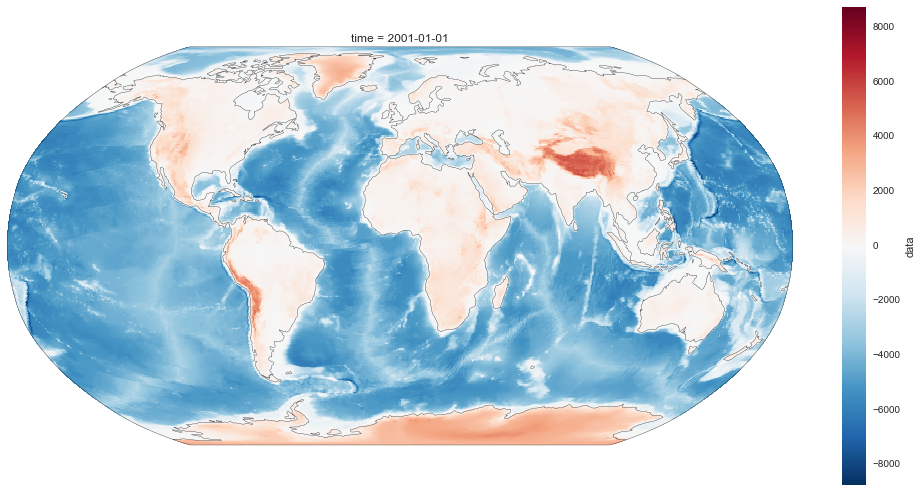

In [6]:
# Plot using xarray
plt.figure(figsize=(14, 7))

# Define the desired output projection using Cartopy. Options listed here:
# http://scitools.org.uk/cartopy/docs/latest/crs/projections.html#cartopy-projection-list
ax = plt.axes(projection=ccrs.Robinson())

# Plot the data
ds.data[0].plot.pcolormesh(ax=ax, 
                           transform=ccrs.PlateCarree(), # Define original data projection
                                                         # PlateCarree is just a Cartesian
                                                         # grid based on lat/lon values,
                                                         # which is what we have in the 
                                                         # original file   
                           x='lon', y='lat', 
                           add_colorbar=True)

# Add coastlines
ax.coastlines()

plt.tight_layout()

This looks good, although connoisseurs may prefer a more interesting projection... 

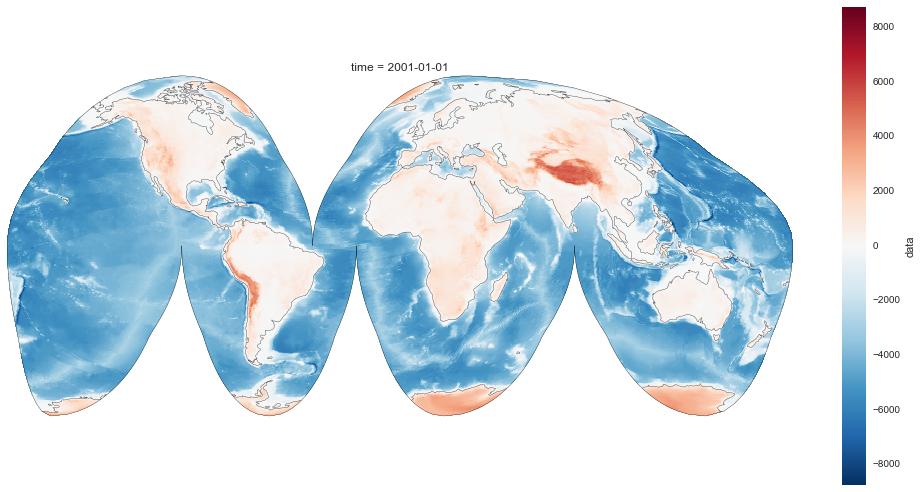

In [7]:
# Plot using xarray
plt.figure(figsize=(14, 7))

# Define the desired output projection using Cartopy
ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())

# Plot the data
ds.data[0].plot.pcolormesh(ax=ax, 
                           transform=ccrs.PlateCarree(),  
                           x='lon', y='lat', 
                           add_colorbar=True)

# Add coastlines
ax.coastlines()

plt.tight_layout()

### 2.3. Pixel elevations for ICPW sites

#### 2.3.1. From the netCDF file using xarray

In the past I've written my own code for extracting time series from netCDF files (see e.g. [here](http://nbviewer.jupyter.org/github/JamesSample/misc/blob/master/extract_ts_from_netcdf.ipynb)), but xarray looks to simplify this a lot. In principle, it's just a matter of providing `lat` and `lon` co-ordinates for the sites of interest, and xarray will return values from the nearest grid cell. However, there appears to be some kind of Windows-related bug that prevents the `method='nearest'` argument from working properly (see [here](https://github.com/pydata/xarray/issues/1140)). I therefore need to manually alter the station co-ordinates first so that they exactly match the grid cell centres. 

In addition, the netCDF metadata shows the longitude values in the elevation file run of 0 to 360, whereas the values in the stations table run from -180 to 180. Longitude values in the stations table less than zero therefore need 360 adding to them to make the co-ordiantes match.

In [8]:
# Shift negative lons to match lons in elev file
lon_shift = stn_df['lon'].values.copy()                 # Copy lon values
lon_shift[lon_shift<0] = lon_shift[lon_shift<0] + 360   # Shift
stn_df['lon_shift'] = lon_shift                         # New column     

# Round stn lat/lon to nearest 0.25 of a degree
stn_df['grid_lat'] = ((stn_df['lat'] - 0.25)*2).round()/2. + 0.25
stn_df['grid_lon'] = ((stn_df['lon_shift'] - 0.25)*2).round()/2. + 0.25

# Check that the correct grid cell has been identified in each case
# Compute upper and lower bounds for each cell
stn_df['lon_l'] = stn_df['grid_lon'] - 0.25
stn_df['lon_u'] = stn_df['grid_lon'] + 0.25
stn_df['lat_l'] = stn_df['grid_lat'] - 0.25
stn_df['lat_u'] = stn_df['grid_lat'] + 0.25

# Check bounds contain stn co-ord
stn_df['lon_b'] = (stn_df['lon_l'] <= stn_df['lon_shift']) &  (stn_df['lon_shift'] < stn_df['lon_u'])
stn_df['lat_b'] = (stn_df['lat_l'] <= stn_df['lat']) &  (stn_df['lat'] < stn_df['lat_u'])

# Reorder cols
stn_df = stn_df[['stn_id', 'stn_code', 'stn_name', 'lat', 'lon', 'lon_shift', 'elev_m', 'lat_l', 
                 'grid_lat', 'lat_u', 'lon_l', 'grid_lon', 'lon_u', 'lat_b', 'lon_b']]

print (stn_df['lon_b'] == True).all()
print (stn_df['lat_b'] == True).all()

stn_df.head()

True
True


,stn_id,stn_code,stn_name,lat,lon,lon_shift,elev_m,lat_l,grid_lat,lat_u,lon_l,grid_lon,lon_u,lat_b,lon_b
0,23469,CA20,"Ontario,Lake373",49.740,-93.793,266.207,424.0,49.5,49.75,50.0,266.0,266.25,266.5,True,True
1,23459,CA08,"Quebec, Lac Laflamme",47.317,-71.117,288.883,777.0,47.0,47.25,47.5,288.5,288.75,289.0,True,True
2,23468,CA19,Ontario. Lake 305,49.689,-93.686,266.314,404.0,49.5,49.75,50.0,266.0,266.25,266.5,True,True
3,23455,CA04,"Ontario, Algoma Region, Turkey Lake",47.050,-84.408,275.592,372.0,47.0,47.25,47.5,275.5,275.75,276.0,True,True
4,23460,CA09,"Quebec, Lac Macleod",47.467,-70.973,289.027,975.0,47.0,47.25,47.5,289.0,289.25,289.5,True,True


Having calculated compatible co-ordinates, it is now easy to extract the elevations using xarray.

In [9]:
# Extract elevation data
dsloc = ds.sel_points(lon=stn_df['grid_lon'].values,
                      lat=stn_df['grid_lat'].values)

# Convert to df
elev_df =  dsloc['data'].to_dataframe()

# Rename cols
elev_df.columns = ['px_elev_m', 'lat2', 'lon2']

# Reset index and drop duplicates
elev_df.reset_index(inplace=True)
elev_df.drop_duplicates(subset=['px_elev_m', 'lat2', 'lon2'],
                        inplace=True)

elev_df.head()

,points,time,px_elev_m,lat2,lon2
0,0,0,395.0,49.75,266.25
1,1,0,633.0,47.25,288.75
3,3,0,431.0,47.25,275.75
4,4,0,345.0,47.25,289.25
5,5,0,101.0,44.25,294.75


In [10]:
# Join to stn_df
df = pd.merge(stn_df, elev_df, how='inner',
              left_on=['grid_lat', 'grid_lon'],
              right_on=['lat2', 'lon2'])

# Get cols of interest
df = df[['stn_id', 'stn_code', 'stn_name', 'lat', 'lon', 
         'lon_shift', 'elev_m', 'px_elev_m']]

df.head()

,stn_id,stn_code,stn_name,lat,lon,lon_shift,elev_m,px_elev_m
0,23469,CA20,"Ontario,Lake373",49.740,-93.793,266.207,424.0,395.0
1,23468,CA19,Ontario. Lake 305,49.689,-93.686,266.314,404.0,395.0
2,23467,CA17,"Ontario,Lake239",49.707,-93.720,266.280,393.0,395.0
3,23466,CA16,"Ontario,Lake224",49.658,-93.717,266.283,408.0,395.0
4,23459,CA08,"Quebec, Lac Laflamme",47.317,-71.117,288.883,777.0,633.0


We can now compare the measured station elevations to the gridded values in the 0.5 degree dataset. In the plot below, there is clearly a relationship, but it is pretty noisy. This isn't too surprising, as 0.5 degrees corresponds to roughly 50 km by 50 km at the equator, and there is obviously a lot of topographic variation at this scale. It also seems that some of the more coastal stations are classified as being in the sea (with negative elevations) at the 0.5 degree scale. These values will need setting back to zero before pefforming any temperature corrections.

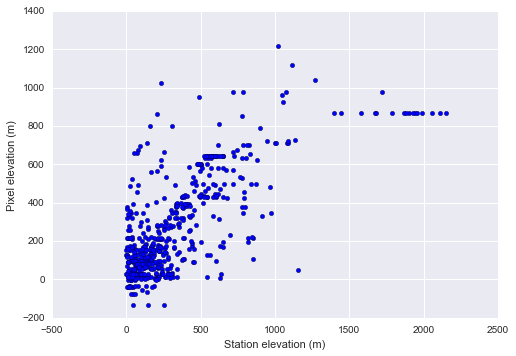

In [11]:
# Compare elvations
plt.scatter(x='elev_m', y='px_elev_m', data=df)
plt.xlabel('Station elevation (m)')
plt.ylabel('Pixel elevation (m)')

#### 2.3.2. From the CRU elevation dataset

The CRU elevation dataset is supplied in .dat format, which is a bit more difficult to read. The code below manipulates the data and extracts the elevations, but it's not as easy to use as xarray.

In [12]:
def geo_idx(dd, dd_array):
    """ Get array indices for specified lat/long co-ordinate.
        Adapted from here:
        http://stackoverflow.com/questions/33789379/
        netcdf-and-python-finding-the-closest-lon-lat-index-given-actual-lon-lat-values
    
    Args:
        dd       Lat or long value in decimal degrees
        dd_array Corresponding array of lat or long values from netCDF
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    
    return geo_idx

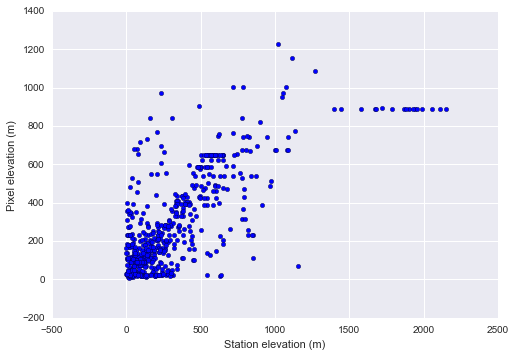

In [13]:
# Get grid indices for each site
stn_df['lat_idx'] = stn_df['lat'].apply(geo_idx, args=(yy[:,0],))
stn_df['lon_idx'] = stn_df['lon'].apply(geo_idx, args=(xx[0],))

# Extract elevations based on indices
px_elev = []
for idx, row in stn_df.iterrows():
    px_elev.append(elev2[row['lat_idx'], row['lon_idx']])

# Add column
stn_df['px_elev_m'] = px_elev

# Plot
plt.scatter(x='elev_m', y='px_elev_m', data=stn_df)
plt.xlabel('Station elevation (m)')
plt.ylabel('Pixel elevation (m)')

These results are identical to those above, except the CRU dataset does not cover the "offshore" cells. Based on this, I'm pretty happy that xarray is performing as expected, so I'll use it below for the climate data processing.

## 3. Climate data

The climate data is here:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015\CRU_Climate_Data

with one netCDF file per variable per decade. The first step is therefore to merge the files from each decade into a single xarray dataset. With a bit of luck, this can be done without having to load everything into memory thanks to the out-of-core computation provided by [Dask](http://dask.pydata.org/en/latest/). See [here](http://xarray.pydata.org/en/stable/io.html#id6) and [here](http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/) for more details.

In [14]:
# Read all the netCDF files and combine into a single dataset
pptn_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
             r'\CRU_Climate_Data\pptn\netcdf\*.nc')
ds = xr.open_mfdataset(pptn_path)
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 420)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 1981-03-16 ...
Data variables:
    pre      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

This is great! There are four netCDF files here with a combined size of about a GB, but it seems I can manipulate them all at once. For example, the code below calculates gridded annual total preciptation *for the entire dataset*.

In [15]:
# Resample grids to annual resolution
ds2 = ds.resample('A', dim='time', how='sum')
ds2

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 35)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * time     (time) datetime64[ns] 1981-12-31 1982-12-31 1983-12-31 ...
Data variables:
    pre      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

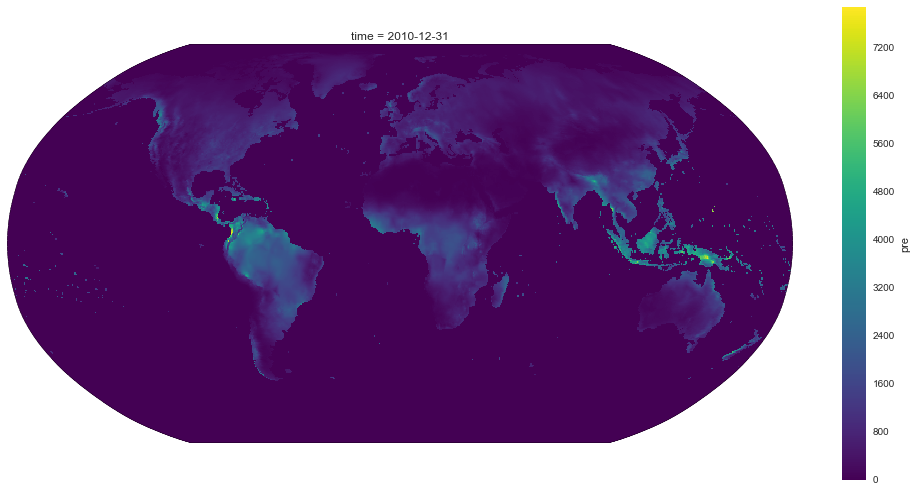

In [16]:
# Plot results for 2010
plt.figure(figsize=(14, 7))

# Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# Plot the data
ds2.sel(time='2010').pre[0].plot.pcolormesh(ax=ax, 
                                            transform=ccrs.PlateCarree(),  
                                            x='lon', y='lat', 
                                            add_colorbar=True)
plt.tight_layout()

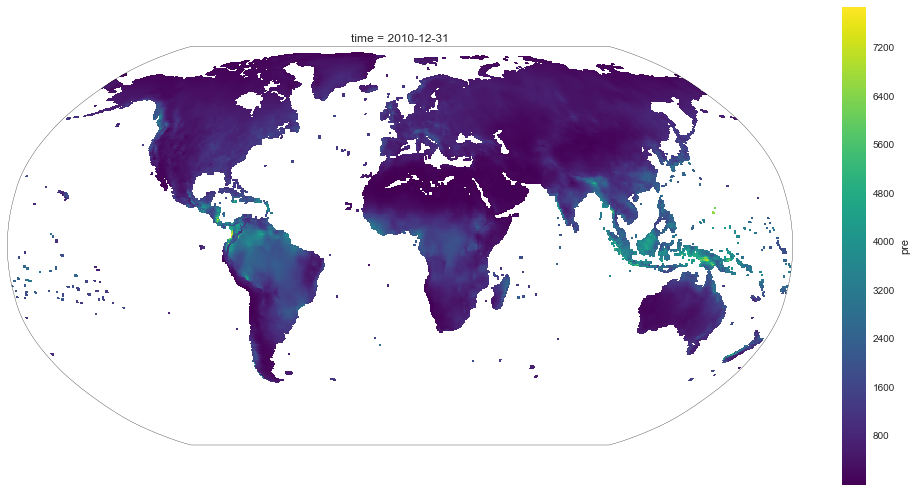

In [17]:
# Plot results for 2010, but setting zeros to NaN
plt.figure(figsize=(14, 7))

# Robinson projection
ax = plt.axes(projection=ccrs.Robinson())

# Plot the data
data = ds2.sel(time='2010')
data = data.where(data>0)
data.pre[0].plot.pcolormesh(ax=ax, 
                            transform=ccrs.PlateCarree(),  
                            x='lon', y='lat', 
                            add_colorbar=True)
plt.tight_layout()

In [18]:
# Calculate monthly average pptn over all years
month_ds = ds.groupby('time.month').mean(dim='time')
month_ds

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\dask\array\numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, month: 12)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pre      (month, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

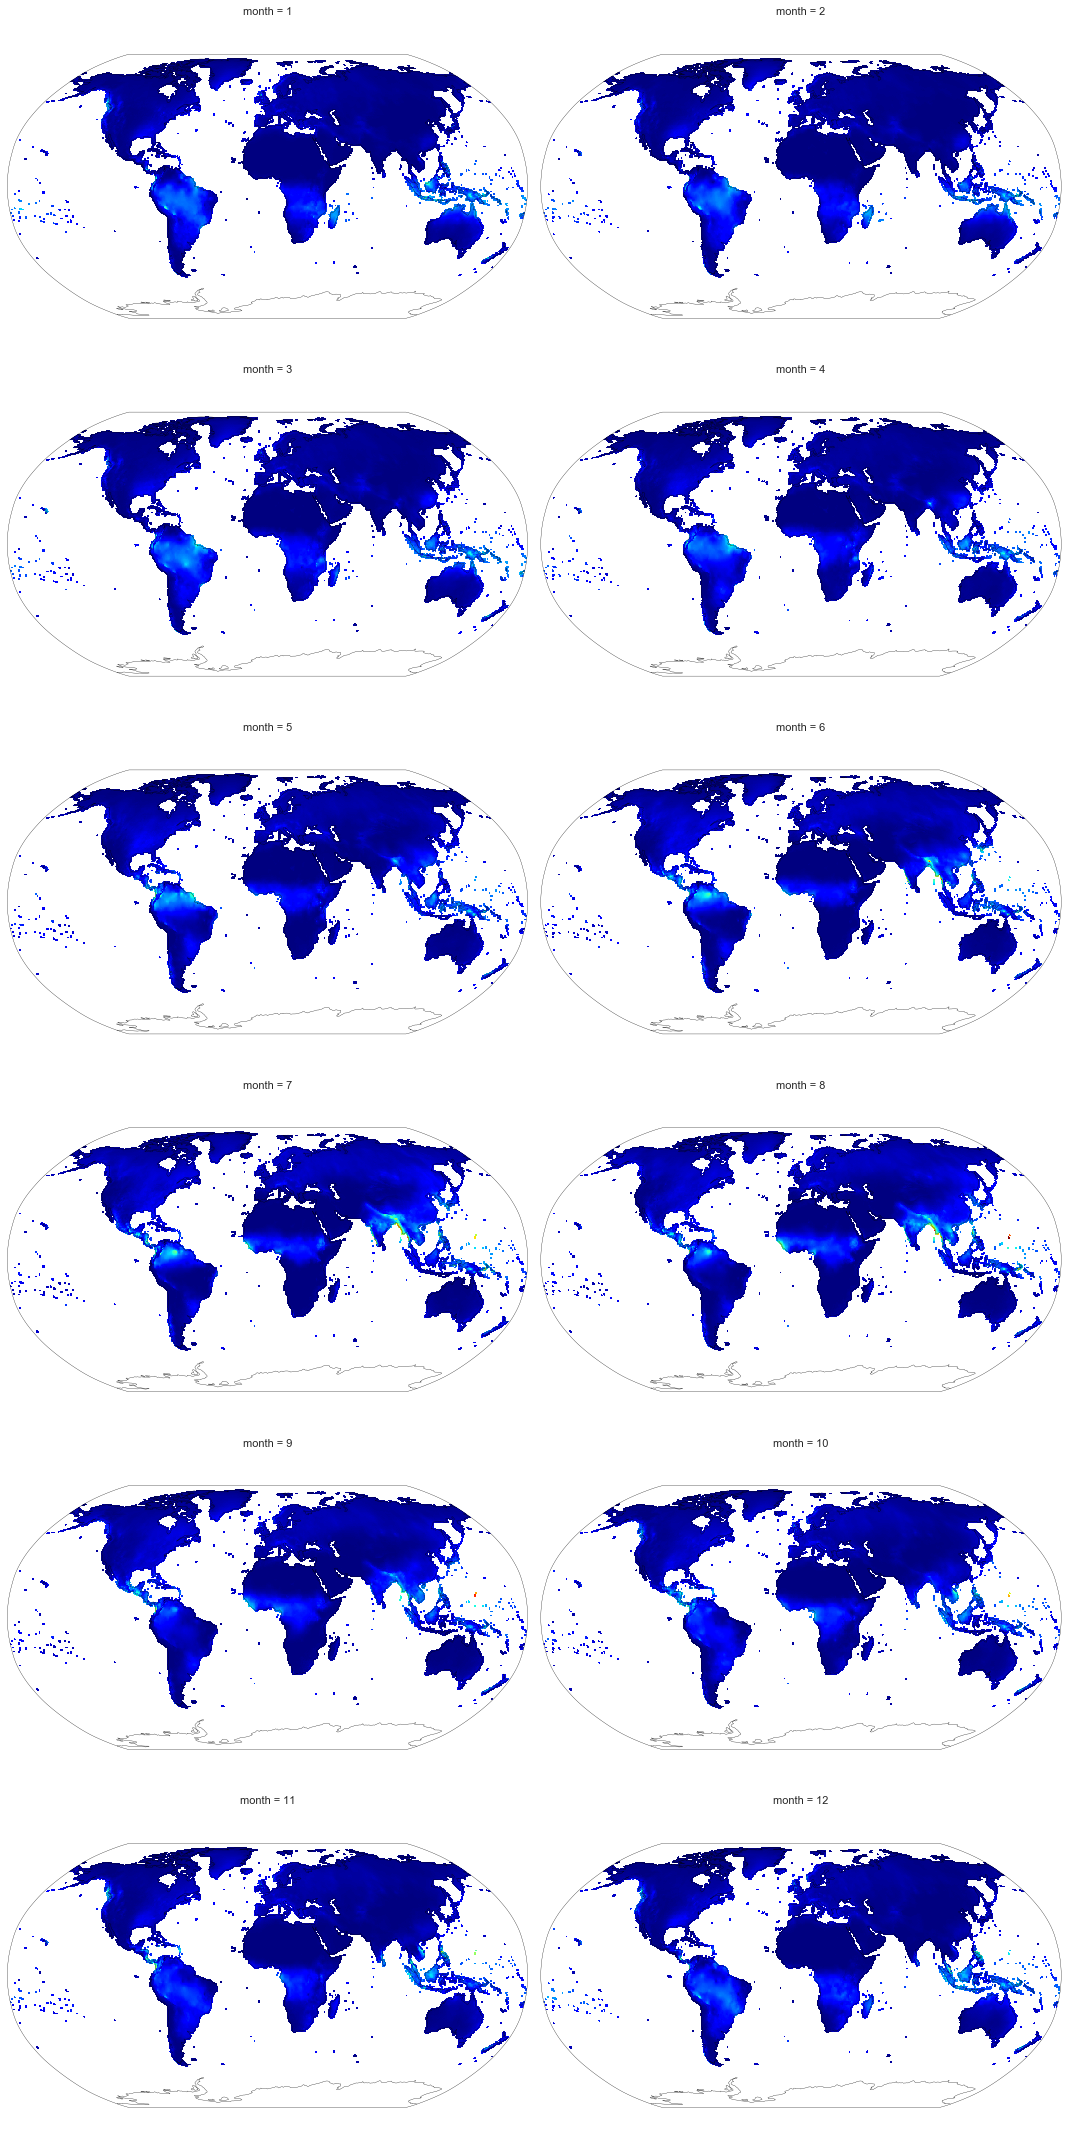

In [19]:
# Plot monthly average pptn over all years
p = month_ds.pre.plot(transform=ccrs.PlateCarree(), 
                      col='month', 
                      col_wrap=2, 
                      cmap='jet',
                      add_colorbar=False, 
                      figsize=(15, 30),                      
                      subplot_kws={'projection':ccrs.Robinson()})

# Add coastlines
for ax in p.axes.flat:
    ax.coastlines()

plt.tight_layout()